<a href="https://colab.research.google.com/github/abdurrahimyilmaz/derm12345_google-derm-foundation/blob/main/derm12345_derm_foundation_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Derm Foundation API Tutorial for DERM12345 Dataset

The ipynb is a demonstration of using the
[Derm Foundation API](https://github.com/Google-Health/imaging-research/tree/master/derm-foundation)
(this API computes embeddings for dermatology-related images).

The contents include how to:

-   Load DERM12345 dataset from a CSV
-   Train a small model using the pre-computed embeddings

## Prerequisites

You must have access to the Dermatology Foundation API. See the project's
[README](https://github.com/Google-Health/imaging-research/blob/master/derm-foundation/README.md)
for details.

## Setup

In [1]:
#@title Install the required packages

!pip install matplotlib tf-models-official>=2.13.0 google-cloud-storage tqdm xgboost

In [2]:
# @title Imports

import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time
from typing import List, Text
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tabulate
import tensorflow as tf
import xgboost as xgb

In [3]:
# @title Global params


class Globals:
  # @markdown GCP project with GCS bucket of interest:
  gcp_project = 'derm12345-foundations'  # @param

  # GCS bucket with data to read:
  gcs_bucket_name = 'derm12345-foundations-dermatology'  # @param

  # @markdown DERM12345 Dataset files:
  # Metadata CSV from DERM12345 dataset to read
  gcs_metadata_csv = 'derm12345_dataset/derm12345_metadata_all.csv'  # @param

  # Images directory:
  gcs_images_dir = 'derm12345_dataset/all_images/all_images'  # @param

  # Column name to use for the small model
  label_column = 'label'  # @param

  # Column to join the CSV to the images by path
  img_join_column = 'image_id' # @param

  # @markdown If precomputed embeddings should be used:
  # When true, use precomputed embeddings instead of generating
  # from scratch.
  gcs_use_precomputed_embeddings = True  # @param {type: "boolean"}

  # Path to precomputed embeddings
  gcs_precomputed_embeddings = 'derm12345_foundation_embeddings.npz'  # @param

  # Access Token for `gcs_bucket_name`.
  # Note: You can also manually create and set this
  #   by using `gcloud auth print-access-token` in your local
  #   environment.
  gcs_creds = None

  # @markdown ---
  # @markdown Vertex AI end-point configuration:
  vertex_endpoint_project_id = '132886652110'  # @param
  vertex_endpoint_id = '180'  # @param
  vertex_endpoint_location = 'us-central1'  # @param

  random_state = 3141
  embeddings_size = 12345
  # @markdown ---
  # @markdown Training Parameters--Adjust this to reduce or increase the training size as a % of total training:
  train_split_size = 0.2 # @param
  # Note: this variable sets the training split. We set it by default to 0.15 to show how effective the model is on a small amount of data. You can increase it to see how more data improves the accuracy.

  ###### Formed during execution:

  # Client for querying GCS
  gcs_storage_client = None

  # Bucket object for loading files
  gcs_bucket = None

  # pd.DataFrame for the loaded metadata_csv
  metadata_df = None

  # Dict from image path -> embedding
  embeddings = dict()

  # pd.DataFrames for training/validation data splits
  df_train = None
  df_validate = None

  # ML model
  model = None

### Authenticate

The following cell is for Colab only. If running elsewhere, authenticate with
the [gcloud CLI](https://cloud.google.com/sdk/gcloud/reference/auth/login).

**WARNING**: The colab auth cell below will result in a pop-up asking you to
enable access. This enables the notebook to interact with all GCP projects you
have access to on your behalf.

In [4]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

In [ ]:
import datetime
import google.auth
import google.auth.transport.requests

Globals.gcs_creds, project = google.auth.default()

#Globals.gcs_creds, project = google.auth.load_credentials_from_file(
#    '/content/derm12345-foundation-c728d4336692.json',
#    ['https://www.googleapis.com/auth/'],
#)

def initial_token_refresh():
  # Refresh credentials so an access token is available.
  auth_req = google.auth.transport.requests.Request()
  Globals.gcs_creds.refresh(auth_req)
  assert (
      Globals.gcs_creds.valid
  ), f'Unexpected error: GCS Credentials are invalid'
  time_until_expiry = (
      Globals.gcs_creds.expiry - datetime.datetime.utcnow()
  ).total_seconds() // 60
  print(
      'Token will expire at'
      f' {Globals.gcs_creds.expiry.strftime("%Y-%m-%d %H:%M:%S")} UTC'
      f' ({time_until_expiry} minutes)'
  )


initial_token_refresh()

Token will expire at 2024-10-15 15:12:48 UTC (59.0 minutes)


## Load DERM12345 Dataset

This colab uses the
[DERM12345 Dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DAXZ7P), which
contains 12,345 images of 40 skin conditions from 1,627 patients.

**NOTE**: Any work that uses this dataset must abide by the restrictions and
citation requirements listed on
[their website](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DAXZ7P).

**Dataset citation**:
```bibtex
@article{yilmaz2024derm12345,
  title={DERM12345: A Large, Multisource Dermatoscopic Skin Lesion Dataset with 40 Subclasses},
  author={Yilmaz, Abdurrahim and Yasar, Sirin Pekcan and Gencoglan, Gulsum and Temelkuran, Burak},
  journal={Scientific Data},
  volume={11},
  number={1},
  pages={1302},
  year={2024},
  publisher={Nature Publishing Group UK London}
}
```

In [ ]:
Globals.metadata_df

image_id  patient_id license   image_type  split     super_class  \
0      DERM_100022  PID_521837   CC-BY  dermoscopic  train     melanocytic   
1      DERM_100075  PID_673449   CC-BY  dermoscopic  train     melanocytic   
2      DERM_100084  PID_786221   CC-BY  dermoscopic  train     melanocytic   
3      DERM_100202  PID_392075   CC-BY  dermoscopic  train  nonmelanocytic   
4      DERM_100221  PID_898020   CC-BY  dermoscopic  train  nonmelanocytic   
...            ...         ...     ...          ...    ...             ...   
12340  DERM_999859  PID_154109   CC-BY  dermoscopic  train     melanocytic   
12341  DERM_999917  PID_299234   CC-BY  dermoscopic   test     melanocytic   
12342  DERM_999985  PID_526575   CC-BY  dermoscopic   test  nonmelanocytic   
12343  DERM_999989  PID_280021   CC-BY  dermoscopic  train  nonmelanocytic   
12344  DERM_999994  PID_415815   CC-BY  dermoscopic  train     melanocytic   

          malignancy   main_class_1   main_class_2                sub_class  \
0             benign     dysplastic     junctional               junctional   
1             benign     dysplastic     junctional               junctional   
2             benign     dysplastic     junctional               junctional   
3      indeterminate  keratinocytic  keratinocytic        actinic_keratosis   
4          malignant  keratinocytic  keratinocytic     basal_cell_carcinoma   
...              ...            ...            ...                      ...   
12340         benign     dysplastic     junctional               junctional   
12341         benign          banal     junctional               junctional   
12342      malignant  keratinocytic  keratinocytic     basal_cell_carcinoma   
12343      malignant  keratinocytic  keratinocytic  squamous_cell_carcinoma   
12344         benign          banal     junctional               junctional   

      label                                           img_path  
0        jd  derm12345_dataset/all_images/all_images/DERM_1...  
1        jd  derm12345_dataset/all_images/all_images/DERM_1...  
2        jd  derm12345_dataset/all_images/all_images/DERM_1...  
3        ak  derm12345_dataset/all_images/all_images/DERM_1...  
4       bcc  derm12345_dataset/all_images/all_images/DERM_1...  
...     ...                                                ...  
12340    jd  derm12345_dataset/all_images/all_images/DERM_9...  
12341    jb  derm12345_dataset/all_images/all_images/DERM_9...  
12342   bcc  derm12345_dataset/all_images/all_images/DERM_9...  
12343   scc  derm12345_dataset/all_images/all_images/DERM_9...  
12344    jb  derm12345_dataset/all_images/all_images/DERM_9...  

[12345 rows x 12 columns]

In [ ]:
# @title Print interesting metadata
def print_metadata_stats(metadata_df: pd.DataFrame) -> None:
  print(f'Num Patients: {len(metadata_df)}')
  print('Column Names:')
  for column in metadata_df.columns:
    print(f'  {column}')
  print(
      f'Column values for "{Globals.label_column}":'
      f' {sorted(set(metadata_df[Globals.label_column]))}'
  )


print_metadata_stats(Globals.metadata_df)

Num Patients: 12345
Column Names:
  image_id
  patient_id
  license
  image_type
  split
  super_class
  malignancy
  main_class_1
  main_class_2
  sub_class
  label
  img_path
Column values for "label": ['acb', 'acd', 'ajb', 'ajd', 'ak', 'alm', 'angk', 'anm', 'bcc', 'bd', 'bdb', 'cb', 'ccb', 'ccd', 'cd', 'ch', 'cjb', 'db', 'df', 'dfsp', 'ha', 'isl', 'jb', 'jd', 'ks', 'la', 'lk', 'lm', 'lmm', 'ls', 'mcb', 'mel', 'mpd', 'pg', 'rd', 'sa', 'scc', 'sk', 'sl', 'srjd']


There are a total of 12345 images. We will sample 3 to display.
Image 6718


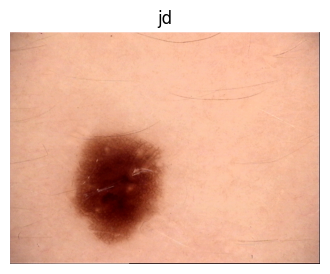

Image 11221


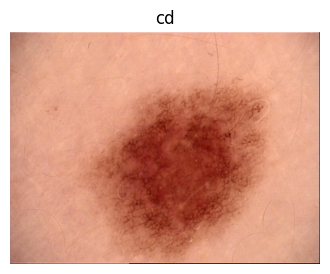

Image 12240


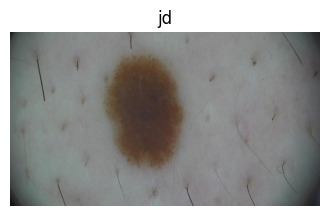

In [ ]:
# @title Display image sample
import io
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def display_image(bucket, image_path, title):
  image = Image.open(io.BytesIO(bucket.blob(image_path).download_as_string()))
  figure_size = 4
  f, axarr = plt.subplots(1, 1, figsize=(figure_size, figure_size))
  axarr.imshow(image, cmap='gray')
  axarr.axis('off')
  axarr.set_title(title)
  plt.show()


def display_images(df, bucket, file_to_visualize=3):
  max_index = len(df['img_path'].values)
  print(
      f'There are a total of {max_index} images. '
      f'We will sample {file_to_visualize} to display.'
  )
  list_of_images = random.sample(range(0, max_index - 1), file_to_visualize)
  for image_idx in list_of_images:
    filename = df['img_path'].values[image_idx]
    diagnostic = df['label'].values[image_idx]
    print('Image %d' % image_idx)
    display_image(bucket, filename, title=diagnostic)


display_images(Globals.metadata_df, Globals.gcs_bucket)

## Load Pre-computed Embeddings

This section loads pre-computed embeddings. To regenerate them, see the
'Generate Embeddings' section below

In [ ]:
# @title Helper: Save/load embeddings via numpy.savez


def convert_to_numpy_dict(embeddings):
  updated_embeddings = {}
  for filepath, embedding in embeddings.items():
    updated_embeddings[filepath] = np.array(embedding)
  return updated_embeddings


def save_embeddings_to_file(
    project_name, bucket_name, object_name, embeddings=None
):
  gcs_storage_client = storage.Client(project_name)
  bucket = gcs_storage_client.bucket(bucket_name)
  blob = bucket.blob(object_name + ".npz") # gcs doesnt save in npz format
  data_dict = embeddings or convert_to_numpy_dict(Globals.embeddings)
  type(data_dict)
  try:
    with blob.open('wb', ignore_flush=True) as f:
      np.savez(f, **data_dict)
  except Exception as e:
    print(f'Saving embeddings failed: {e}')
    raise


def load_embeddings_from_file(project_name, bucket_name, object_name):
  gcs_storage_client = storage.Client(project_name)
  bucket = gcs_storage_client.bucket(bucket_name)
  blob = bucket.blob(object_name)
  embeddings = dict()
  with blob.open('rb') as f:
    x = np.load(f)
    for k, v in x.items():
      embeddings[k] = v
  return embeddings



In [ ]:
# @title Save trained embeddings / For just step by step calculation - Dont use
#save_embeddings_to_file(
#    "derm12345-foundations", "derm12345-foundations-dermatology", "all_embeddings", embeddings=None)


In [ ]:
# @title Load trained embeddings / For just step by step calculation - Dont Use
#Globals.embeddings = load_embeddings_from_file("derm12345-foundations", "derm12345-foundations-dermatology", "train_embeddings.npz")

In [ ]:
#@title Load embeddings
%%time
if Globals.gcs_use_precomputed_embeddings:
  err_msg = ('A path to precomputed_embeddings must be set when '
             '`gcs_use_precomputed_embeddings` is set. Found '
            f'{Globals.gcs_precomputed_embeddings}')
  assert Globals.gcs_precomputed_embeddings, err_msg
  Globals.embeddings = load_embeddings_from_file(
      Globals.gcp_project,
      Globals.gcs_bucket_name,
      Globals.gcs_precomputed_embeddings)
print(f'Loaded {len(Globals.embeddings)} embeddings.')

Loaded 12345 embeddings.
CPU times: user 13.7 s, sys: 3.68 s, total: 17.4 s
Wall time: 1min 29s


In [ ]:
Globals.embeddings['derm12345_dataset/all_images/train_all/DERM_100022.jpg']

array([0.0696122 , 0.        , 0.        , ..., 0.        , 0.00242793,
       0.00615578])

In [ ]:
Globals.embeddings['derm12345_dataset/all_images/test_all/DERM_100794.jpg']

array([0.01177941, 0.        , 0.        , ..., 0.        , 0.04311363,
       0.        ])

## Generate Embeddings

**IMPORTANT**: You must have access to the Dermatology Foundation API. See the
project's
[README](https://github.com/Google-Health/imaging-research/blob/master/derm-foundation/README.md)
for details.

**NOTE**: This takes a long time (~hours) to run for a lot of images.

In [ ]:
# @title Helpers: call Vertex predict
from typing import List
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf import struct_pb2

PredictionServiceClient = aiplatform.gapic.PredictionServiceClient


def create_prediction_service_client_and_endpoint_path():
  client_options = {
      'api_endpoint': (
          f'{Globals.vertex_endpoint_location}-aiplatform.googleapis.com'
      )
  }
  # Initialize client that will be used to create and send requests.
  # This client only needs to be created once, and can be reused for multiple
  # requests.
  client = PredictionServiceClient(client_options=client_options)
  endpoint_path = client.endpoint_path(
      project=Globals.vertex_endpoint_project_id,
      location=Globals.vertex_endpoint_location,
      endpoint=Globals.vertex_endpoint_id,
  )
  return client, endpoint_path


def get_prediction_instances(image_uris: List[str]):
  """Returns a list of JSON dicts to pass as Vertex PredictionService instances."""
  instances = []
  for image_uri in image_uris:
    instance_dict = {
        'bucket_name': Globals.gcs_bucket_name,
        'object_uri': image_uri,
        'bearer_token': Globals.gcs_creds.token,
    }
    instance = json_format.ParseDict(instance_dict, struct_pb2.Value())
    instances.append(instance)
  return instances


def predict(
    client: PredictionServiceClient, endpoint_path: str, image_uris: List[str]
):
  """Calls predict for a Vertex endpoint using the given image paths."""
  instances = get_prediction_instances(image_uris)
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, struct_pb2.Value())

  return client.predict(
      endpoint=endpoint_path, instances=instances, parameters=parameters
  )

In [ ]:
%%time
#@title Example predict request
def run_single_predict_request(bucket_name, object_uri):
  client, endpoint_path = create_prediction_service_client_and_endpoint_path()
  assert Globals.gcs_creds.token, 'GCS Credential token is not valid. Re-run "Authenticate" section?'
  instance_dict = {
      'bucket_name': bucket_name,
      'object_uri': object_uri,
      'bearer_token': Globals.gcs_creds.token,
  }
  instance = json_format.ParseDict(instance_dict, struct_pb2.Value())
  instances = [instance]
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, struct_pb2.Value())

  return client.predict(
      endpoint=endpoint_path, instances=instances, parameters=parameters
  )

# Example of how to run:
TEST_PREDICT_VAL = run_single_predict_request(
    bucket_name=Globals.gcs_bucket_name,
    object_uri='derm12345_dataset/all_images/train_all/DERM_100022.jpg')

# Note: The embedding is in TEST_PREDICT_VAL.predictions
print(TEST_PREDICT_VAL.deployed_model_id)
print(TEST_PREDICT_VAL.model)
print(TEST_PREDICT_VAL.model_display_name)
print(TEST_PREDICT_VAL.model_version_id)

8807129919927615488
projects/132886652110/locations/us-central1/models/dermatology
dermatology
5
CPU times: user 59.7 ms, sys: 17.9 ms, total: 77.7 ms
Wall time: 7.05 s


In [ ]:
if Globals.gcs_use_precomputed_embeddings:
  # Check that the embeddings match.
  precomputed = Globals.embeddings['derm12345_dataset/all_images/train_all/DERM_100022.jpg']
  assert len(precomputed) == len(TEST_PREDICT_VAL.predictions[0]), (
      f'Expected equal lengths: {len(precomputed)} !='
      f' {len(TEST_PREDICT_VAL.predictions[0])}'
  )
  print(f'First 10 items of the `precomputed` list:')
  print(precomputed[:10])
  print(f'First 10 items of the embedding from the above API call:')
  print(list(TEST_PREDICT_VAL.predictions[0])[:10])
  print('Asserting that the lists are equal:')
  assert list(precomputed) == TEST_PREDICT_VAL.predictions[0]

First 10 items of the `precomputed` list:
[0.0696122  0.         0.         0.86998493 0.00161755 0.
 0.         0.00947277 0.         0.06346034]
First 10 items of the embedding from the above API call:
[0.069612205, 0.0, 0.0, 0.869984925, 0.00161754701, 0.0, 0.0, 0.00947276503, 0.0, 0.0634603351]
Asserting that the lists are equal:


In [ ]:
BATCH_COUNTER = collections.Counter()

In [ ]:
#@title Generate embeddings concurrently
%%time
import concurrent.futures
import time

def refresh_credentials():
  # Refreshing is required b/c this can take longer than the typical 1-hr
  # timeout.
  auth_req = google.auth.transport.requests.Request()
  Globals.gcs_creds.refresh(auth_req)

def run_predict(client, endpoint_path, img_paths, batch_id=None):
  # Ensure the GCS token has not yet expired. Otherwise `predict`
  # returns `500 Internal Error`.
  if not Globals.gcs_creds.valid:
    refresh_credentials()
    if not Globals.gcs_creds.valid:
      print('GCP Credentials are not valid.')
      return (None, None)
  start = time.time()
  try:
    predictions = predict(client, endpoint_path, img_paths)
  except Exception as e:
    print(f'Error generating embedding for {img_paths}: {e}')
    return (None, None)

  end = time.time()
  return (zip(img_paths, predictions.predictions), end-start, batch_id)


def generate_embeddings_concurrently(df, batch_size=1, num_workers=10):
  """Calls the API to compute embeddings for all images with no embedding yet."""
  # Generate batches of image paths to run the `predict` function with
  all_path_args = []
  for batch_start in np.arange(0, len(df), batch_size):
    batch_df = df.iloc[batch_start:batch_start+batch_size]
    img_paths = list(batch_df['img_path'])
    skip_iteration = True
    for img_path in img_paths:
      if img_path not in Globals.embeddings:
        skip_iteration = False
        break
    if skip_iteration:
      print(f'(skipped) {batch_start}')
      continue
    all_path_args.append(img_paths)

  client, endpoint_path = create_prediction_service_client_and_endpoint_path()
  total_embeddings = 0

  # Concurrently run `predict` requests for all image paths.
  overall_start = time.time()
  batch_counter = collections.Counter()
  with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(run_predict, client, endpoint_path, arg, batch_id=i) for i, arg in enumerate(all_path_args)]
    for future in concurrent.futures.as_completed(futures):
      preds, batch_time, batch_id = future.result()
      if preds is not None:
        print(f'{batch_id}: {batch_time}')
        batch_counter[int(batch_time)] += 1
        BATCH_COUNTER[int(batch_time)] += 1
        for img_path, pred in preds:
          Globals.embeddings[img_path] = pred
          total_embeddings += 1
  overall_end = time.time()
  print(f'Total embeddings retrieved: {total_embeddings}')
  print(f'Total time: {overall_end-overall_start}s ({overall_end-overall_start/60.0:.1f})')
  return batch_counter

REQUEST_TIMES = None
if Globals.gcs_use_precomputed_embeddings:
  print(f'WARNING: Skipping calculating embeddings. Precomputed embeddings will be used instead.')
if not Globals.gcs_use_precomputed_embeddings:
  # Note: You can scale up the number of workers after ~10m of making a high
  # volume of API calls.
  REQUEST_TIMES = generate_embeddings_concurrently(Globals.metadata_df)

CPU times: user 95 µs, sys: 0 ns, total: 95 µs
Wall time: 83.7 µs


In [ ]:
print(len(Globals.embeddings))

12345


In [ ]:
for batch_time in sorted(BATCH_COUNTER):
  print(f'{batch_time}: {BATCH_COUNTER[batch_time]}')

## Prepare training data

In [ ]:
len(Globals.embeddings)

12345

In [ ]:
len(Globals.metadata_df)

12345

In [ ]:
# prompt: edit pandas dataframe column in a for loop

for index, row in Globals.metadata_df.iterrows():
  if Globals.metadata_df['label'][index] == 'acd' or Globals.metadata_df['label'][index] == 'ajd' or \
  Globals.metadata_df['label'][index] == 'ccd' or Globals.metadata_df['label'][index] == 'cd' or \
  Globals.metadata_df['label'][index] == 'jd' or Globals.metadata_df['label'][index] == 'srjd' or \
  Globals.metadata_df['label'][index] == 'rd':
    Globals.metadata_df['label'][index] = 'dysplastic'
  elif Globals.metadata_df['label'][index] == 'acb' or Globals.metadata_df['label'][index] == 'ccb' or \
  Globals.metadata_df['label'][index] == 'mcb' or Globals.metadata_df['label'][index] == 'cb' or \
  Globals.metadata_df['label'][index] == 'bdb' or Globals.metadata_df['label'][index] == 'db' or \
  Globals.metadata_df['label'][index] == 'ajb' or Globals.metadata_df['label'][index] == 'cjb' or \
  Globals.metadata_df['label'][index] == 'jb':
    Globals.metadata_df['label'][index] = 'banal'
  elif Globals.metadata_df['label'][index] == 'isl' or Globals.metadata_df['label'][index] == 'ls' or \
  Globals.metadata_df['label'][index] == 'sl':
    Globals.metadata_df['label'][index] = 'lentigo'
  elif Globals.metadata_df['label'][index] == 'alm' or Globals.metadata_df['label'][index] == 'anm' or \
  Globals.metadata_df['label'][index] == 'lm' or Globals.metadata_df['label'][index] == 'lmm' or \
  Globals.metadata_df['label'][index] == 'mel':
    Globals.metadata_df['label'][index] = 'melanoma'
  elif Globals.metadata_df['label'][index] == 'sk' or Globals.metadata_df['label'][index] == 'lk':
    Globals.metadata_df['label'][index] = 'sk_lk'
  elif Globals.metadata_df['label'][index] == 'df':
    Globals.metadata_df['label'][index] = 'df'
  elif Globals.metadata_df['label'][index] == 'angk' or Globals.metadata_df['label'][index] == 'ha' or \
  Globals.metadata_df['label'][index] == 'la' or Globals.metadata_df['label'][index] == 'pg' or \
  Globals.metadata_df['label'][index] == 'sa':
    Globals.metadata_df['label'][index] = 'vasc'
  elif Globals.metadata_df['label'][index] == 'ak':
    Globals.metadata_df['label'][index] = 'ak'
  elif Globals.metadata_df['label'][index] == 'bcc':
    Globals.metadata_df['label'][index] = 'bcc'
  elif Globals.metadata_df['label'][index] == 'scc' or Globals.metadata_df['label'][index] == 'bd':
    Globals.metadata_df['label'][index] = 'scc'
  elif Globals.metadata_df['label'][index] == 'ch' or Globals.metadata_df['label'][index] == 'mpd':
    Globals.metadata_df['label'][index] = 'ch_mpd'
  elif Globals.metadata_df['label'][index] == 'dfsp':
    Globals.metadata_df['label'][index] = 'dfsp'
  elif Globals.metadata_df['label'][index] == 'ks':
    Globals.metadata_df['label'][index] = 'ks'

Streaming output truncated to the last 5000 lines.

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Globals.metadata_df['label'][index] = 'dysplastic'
<ipython-input-24-d3154d0d9816>:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to pe

In [ ]:
Globals.metadata_df.head()

image_id  patient_id license   image_type  split     super_class  \
0  DERM_100022  PID_521837   CC-BY  dermoscopic  train     melanocytic   
1  DERM_100075  PID_673449   CC-BY  dermoscopic  train     melanocytic   
2  DERM_100084  PID_786221   CC-BY  dermoscopic  train     melanocytic   
3  DERM_100202  PID_392075   CC-BY  dermoscopic  train  nonmelanocytic   
4  DERM_100221  PID_898020   CC-BY  dermoscopic  train  nonmelanocytic   

      malignancy   main_class_1   main_class_2             sub_class  \
0         benign     dysplastic     junctional            junctional   
1         benign     dysplastic     junctional            junctional   
2         benign     dysplastic     junctional            junctional   
3  indeterminate  keratinocytic  keratinocytic     actinic_keratosis   
4      malignant  keratinocytic  keratinocytic  basal_cell_carcinoma   

        label                                           img_path  
0  dysplastic  derm12345_dataset/all_images/all_images/DERM_1...  
1  dysplastic  derm12345_dataset/all_images/all_images/DERM_1...  
2  dysplastic  derm12345_dataset/all_images/all_images/DERM_1...  
3          ak  derm12345_dataset/all_images/all_images/DERM_1...  
4         bcc  derm12345_dataset/all_images/all_images/DERM_1...

In [ ]:
# Check that we have an embedding for every image
if len(Globals.embeddings) < len(Globals.metadata_df):
  raise ValueError(
      f'Expected {len(Globals.metadata_df)} embeddings to be present. '
      f'Got {len(Globals.embeddings)}.\n'
      'Maybe the "Generate embeddings" cell should be run again? This can '
      'happen if there are intermittent API errors.'
  )

In [ ]:
Globals.df_train = Globals.metadata_df[Globals.metadata_df['split'] == "train"]
Globals.df_validate = Globals.metadata_df[Globals.metadata_df['split'] == "test"]

In [ ]:
def print_column_distribution_info(df, label_column):
  c = collections.Counter(df[label_column])
  total = sum(c.values())
  warnings = []
  for i in sorted(c.keys()):
    v = c[i]
    print(f'  {i} {v}/{total} ({100.0*v/total:.0f}%)')
    if v < 20:
      warnings.append(
          f'Less than 20 examples found for {i} ({v} examples). '
          'It will be difficult to learn from or evaluate so few examples!'
      )
  print('\n'.join(warnings))


print('df_train:')
print_column_distribution_info(
    Globals.df_train, label_column=Globals.label_column
)
print('df_validate:')
print_column_distribution_info(
    Globals.df_validate, label_column=Globals.label_column
)

df_train:
  ak 42/9860 (0%)
  banal 3087/9860 (31%)
  bcc 338/9860 (3%)
  ch_mpd 16/9860 (0%)
  df 144/9860 (1%)
  dfsp 3/9860 (0%)
  dysplastic 4868/9860 (49%)
  ks 12/9860 (0%)
  lentigo 70/9860 (1%)
  melanoma 318/9860 (3%)
  scc 241/9860 (2%)
  sk_lk 498/9860 (5%)
  vasc 223/9860 (2%)
Less than 20 examples found for ch_mpd (16 examples). It will be difficult to learn from or evaluate so few examples!
Less than 20 examples found for dfsp (3 examples). It will be difficult to learn from or evaluate so few examples!
Less than 20 examples found for ks (12 examples). It will be difficult to learn from or evaluate so few examples!
df_validate:
  ak 11/2485 (0%)
  banal 774/2485 (31%)
  bcc 85/2485 (3%)
  ch_mpd 5/2485 (0%)
  df 36/2485 (1%)
  dfsp 1/2485 (0%)
  dysplastic 1223/2485 (49%)
  ks 4/2485 (0%)
  lentigo 19/2485 (1%)
  melanoma 82/2485 (3%)
  scc 62/2485 (2%)
  sk_lk 126/2485 (5%)
  vasc 57/2485 (2%)
Less than 20 examples found for ak (11 examples). It will be difficult to lear

## Dataset Specs
Note for the below cell: DERM12345 dataset was splitted into train and test set based on patient ID. However, there are some overlappings for small classes (dfsp, mpd, and sa) because lack of enough patients.

In [ ]:
# @title Verify train and test sets have no overlapping patients
def verify_no_patient_intersection(df_train, df_validate):
  train_pids = set(df_train['patient_id'])
  validate_pids = set(df_validate['patient_id'])
  intersection = train_pids.intersection(validate_pids)
  assert (
      len(intersection) == 0
  ), f'Train and validate intersect ({len(intersection)}): {intersection}'


verify_no_patient_intersection(Globals.df_train, Globals.df_validate)
Globals.df_train

AssertionError: Train and validate intersect (6): {'PID_609408', 'PID_910308', 'PID_656166', 'PID_713986', 'PID_970532', 'PID_491274'}

In [ ]:
# @title Library: display_str_histogram


def display_single_hist(ax, df, key, title=None):
  series = df[key]
  d = series.value_counts().to_dict()
  ax.bar(list(d.keys()), list(d.values()))
  ax.set_xlabel('Category')
  ax.set_ylabel('Count')
  title = title or f'Histogram of {key}'
  ax.set_title(title)


def display_str_histogram(dfs, key, titles=[]):
  assert len(dfs) < 5, "More than 5 dataframes won't look good"
  if len(dfs) == 1:
    fig, ax = plt.subplots()
    display_single_hist(ax, dfs[0], key, titles[0] if titles else '')
    return
  fig, axes = plt.subplots(1, len(dfs))
  for df, ax, title in zip(dfs, axes, titles):
    series = df[key]
    d = series.value_counts().to_dict()
    ax.bar(list(d.keys()), list(d.values()))
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    title = title or f'Histogram of {key}'
    ax.set_title(title)
  plt.tight_layout()
  plt.show()


#display_str_histogram(
#    [Globals.df_train, Globals.df_validate],
#    'gender',
#    titles=['gender of train set', 'gender of test set'],
#)

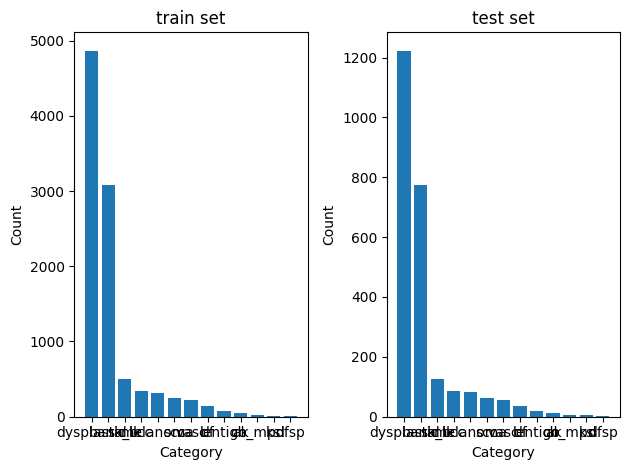

In [ ]:
# @title Histogram of 'diagnostic' column values
display_str_histogram(
    [Globals.df_train, Globals.df_validate],
    Globals.label_column,
    titles=['train set', 'test set'],
)

## Train a model

In [ ]:
Globals.all_col_vals = ['ak',
 'banal',
 'bcc',
 'ch_mpd',
 'df',
 'dfsp',
 'dysplastic',
 'ks',
 'lentigo',
 'melanoma',
 'scc',
 'sk_lk',
 'vasc'
 ]

In [ ]:
# @title Training Functions
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

def make_dataset_train(
    df,
    embeddings_map,
    label_key,
    all_categories=Globals.all_col_vals,
    num_samples=None,
):
  """Returns a tuple of (embeddings, int_class_labels) for the given df."""
  embeddings = []
  i = 0
  for _, row in df.iterrows():
    k = row["img_path"]

    # Index editing to match embedding information and file location
    first_index = k.find("all_images")

    second_index = k.find("all_images", first_index + len("all_images"))

    k = k[:second_index] + "train_all" + k[second_index + len("all_images"):]

    embeddings.append(embeddings_map[k])
    if num_samples and i > num_samples:
      break
    i += 1
  int_labels = [
      all_categories.index(x) for x in df[label_key][: len(embeddings)]
  ]
  return embeddings, int_labels


#def train_model(df_train, embeddings, label_column=Globals.label_column):
#  """Returns a sklearn LogisticRegression model fit to the df_train."""
#  #train_x, train_y = make_dataset(df_train, embeddings, label_column)
#  # https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
#  model = LogisticRegression(
#      penalty="l2",
#      solver="saga",
#      multi_class="multinomial",
#      max_iter=200,
#      random_state=Globals.random_state,
#  )
#  model = model.fit(train_x, train_y)
#  return model

train_x, train_y = make_dataset_train(Globals.df_train, Globals.embeddings, Globals.label_column)

In [ ]:
classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(train_x, train_y)

Globals.model = classifier

In [ ]:
# The reference model in demo notebook
classifier = LogisticRegression(
      penalty="l2",
      solver="saga",
      multi_class="multinomial",
      max_iter=200,
      random_state=Globals.random_state,
  )
classifier = classifier.fit(train_x, train_y)

Globals.model = classifier

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
classifier = xgb.XGBClassifier()
classifier = classifier.fit(train_x, train_y)

Globals.model = classifier

In [ ]:
# a similar mlp is built similar to fully connected part of deep learning
classifier = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', batch_size=16)
classifier = classifier.fit(train_x, train_y)

Globals.model = classifier

In [ ]:
# @title Save the model
#import pickle

# save
#with open('xgb_model.pkl','wb') as f:
#    pickle.dump(xgb_classifier,f)

## Evaluate results

In [ ]:
# @title Create `Globals.eval_df`

def make_dataset_test(
    df,
    embeddings_map,
    label_key,
    all_categories=Globals.all_col_vals,
    num_samples=None,
):
  """Returns a tuple of (embeddings, int_class_labels) for the given df."""
  embeddings = []
  i = 0
  for _, row in df.iterrows():
    k = row["img_path"]

    first_index = k.find("all_images")

    second_index = k.find("all_images", first_index + len("all_images"))

    k = k[:second_index] + "test_all" + k[second_index + len("all_images"):]

    embeddings.append(embeddings_map[k])
    if num_samples and i > num_samples:
      break
    i += 1
  int_labels = [
      all_categories.index(x) for x in df[label_key][: len(embeddings)]
  ]
  return embeddings, int_labels

def get_eval_df(
    df,
    model,
    embeddings=Globals.embeddings,
    label_column=Globals.label_column,
    all_categories=Globals.all_col_vals,
):
  """Runs predict and returns a DataFrame with the predictions."""
  eval_embeddings, eval_labels = make_dataset_test(df, embeddings, label_column)
  pred = model.predict(eval_embeddings)
  pred_floats = model.predict_proba(eval_embeddings)
  int_labels = lambda col: [all_categories.index(x) for x in col]
  return eval_embeddings, pd.DataFrame({
      'prediction_name': [all_categories[i] for i in pred],
      'prediction': pred,
      'max_prediction_float': [max(p) for p in pred_floats],
      'all_prediction_float': list(pred_floats),
      'groundtruth_name': df[label_column],
      'groundtruth': int_labels(df[label_column]),
  })


eval_embeddings, Globals.eval_df = get_eval_df(
    Globals.df_validate, Globals.model
)
Globals.eval_df

prediction_name  prediction  max_prediction_float  \
13              banal           1              0.514223   
16         dysplastic           6              0.983913   
31              banal           1              0.674842   
41         dysplastic           6              0.919916   
42         dysplastic           6              0.735564   
...               ...         ...                   ...   
12332           banal           1              0.798417   
12334           banal           1              0.715415   
12338      dysplastic           6              0.609110   
12341      dysplastic           6              0.732294   
12342             scc          10              0.632984   

                                    all_prediction_float groundtruth_name  \
13     [2.711174928984025e-07, 0.5142227331154673, 1....       dysplastic   
16     [6.274769863291533e-10, 0.010287113052082464, ...       dysplastic   
31     [1.3764215234135716e-11, 0.6748415727370156, 2...       dysplastic   
41     [1.259796938080287e-10, 0.08007974638141016, 2...       dysplastic   
42     [1.717834252851973e-10, 0.26441908396450087, 4...       dysplastic   
...                                                  ...              ...   
12332  [4.0479501494623627e-10, 0.7984172433632523, 1...       dysplastic   
12334  [1.477880956552438e-09, 0.7154151408605538, 6....         melanoma   
12338  [2.750051118709229e-10, 0.39083108887748236, 1...       dysplastic   
12341  [1.0216214418513302e-06, 0.25837694183524107, ...            banal   
12342  [1.2650254070126597e-07, 1.504322570878553e-06...              bcc   

       groundtruth  
13               6  
16               6  
31               6  
41               6  
42               6  
...            ...  
12332            6  
12334            9  
12338            6  
12341            1  
12342            2  

[2485 rows x 6 columns]

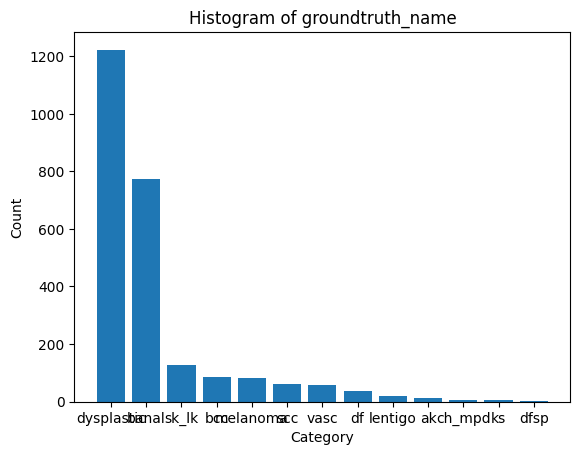

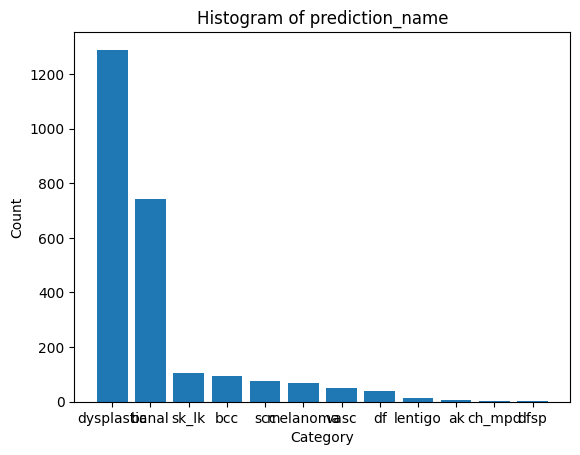

In [ ]:
# @title Histogram: prediction vs. label

display_str_histogram([Globals.eval_df], 'groundtruth_name')
display_str_histogram([Globals.eval_df], 'prediction_name')

-- Model used 9860 training examples
-- Breakdown by class:
label
ak              42
banal         3087
bcc            338
ch_mpd          16
df             144
dfsp             3
dysplastic    4868
ks              12
lentigo         70
melanoma       318
scc            241
sk_lk          498
vasc           223
Name: patient_id, dtype: int64
Note that there are very few Melanoma(MEL) examples. It's unlikely the model will learn this concept well unless more examples are provided.
-- Evaluation uses 2485 total examples
-- Histogram of dataset sizes by class:


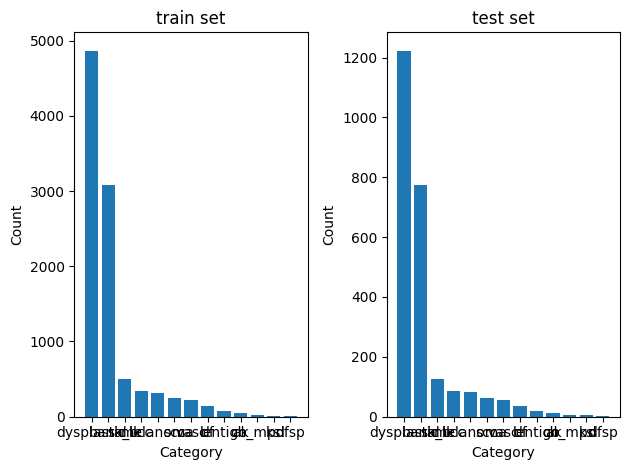

In [ ]:
# @title Dataset sizes


def print_data_size():
  """Prints relevant dataset size information to keep in mind."""
  print(f'-- Model used {len(Globals.df_train)} training examples')
  print(f'-- Breakdown by class:')
  agg = Globals.df_train.groupby(by=Globals.label_column)['patient_id'].count()
  print(agg)
  print(
      "Note that there are very few Melanoma(MEL) examples. It's unlikely the "
      'model will learn this concept well unless more examples are provided.'
  )
  print(f'-- Evaluation uses {len(Globals.df_validate)} total examples')
  print('-- Histogram of dataset sizes by class:')
  display_str_histogram(
      [Globals.df_train, Globals.df_validate],
      Globals.label_column,
      titles=['train set', 'test set'],
  )


print_data_size()

# Results for Deep Learning and Traditional Machine Learning Models
ResNet-50 - Weighted Accuracy: 0.50 \\
InceptionResNetV2 - Weighted Accuracy: 0.58 \\
Xception - Weighted Accuracy: 0.59 \\
XGBoost - Weighted Accuracy: 0.59 \\
MLP - Weighted Accuracy: 0.56 \\
kNN - Weighted Accuracy: 0.41 \\
Logistic Regression - Weighted Accuracy: 0.41

# Results for XGBoost

In [ ]:
# @title Classification report for XGBoost
import sklearn


def get_classification_report(eval_df):
  gt_labels = eval_df[f'groundtruth_name'].values
  pred = eval_df[f'prediction_name'].values
  classification_report = sklearn.metrics.classification_report(
      y_true=gt_labels, y_pred=pred
  )
  print('Classification report:')
  print(classification_report)


get_classification_report(Globals.eval_df)

Classification report:
              precision    recall  f1-score   support

          ak       0.75      0.27      0.40        11
       banal       0.59      0.53      0.56       774
         bcc       0.59      0.69      0.64        85
      ch_mpd       1.00      0.20      0.33         5
          df       0.55      0.33      0.41        36
        dfsp       1.00      1.00      1.00         1
  dysplastic       0.73      0.83      0.78      1223
          ks       0.00      0.00      0.00         4
     lentigo       0.50      0.11      0.17        19
    melanoma       0.62      0.46      0.53        82
         scc       0.54      0.55      0.54        62
       sk_lk       0.63      0.44      0.52       126
        vasc       0.86      0.77      0.81        57

    accuracy                           0.68      2485
   macro avg       0.64      0.48      0.52      2485
weighted avg       0.67      0.68      0.67      2485



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# @title Other metrics (cohen kappa, matthews coefficient, log loss) for XGBoost
from sklearn import metrics


def get_other_eval_metrics(eval_df):
  label_names = eval_df[f'groundtruth_name'].values
  label_ints = eval_df[f'groundtruth'].values
  pred_names = eval_df[f'prediction_name'].values
  pred_floats = list(eval_df[f'all_prediction_float'].values)
  predictions = tf.keras.utils.to_categorical(
      eval_df[f'prediction'].values, num_classes=len(Globals.all_col_vals)
  )
  # metrics:
  cohen_kappa = metrics.cohen_kappa_score(
      label_names, pred_names
  )  # target: 0.8
  labels = np.unique(label_names)

  matthews = metrics.matthews_corrcoef(label_names, pred_names)  # target: 0.7
  log_loss = metrics.log_loss(label_ints, pred_floats)  # target: 0
  auc = metrics.roc_auc_score(label_names, predictions, multi_class='ovr',average=None)
  auc_string = []
  for i, label in enumerate(labels):
    auc_string.append(f'{label}: {auc[i]}')
  return {
      'cohen_kappa': cohen_kappa,
      'matthews': matthews,
      'log_loss': log_loss,
      'auc': auc_string
  }


evals = get_other_eval_metrics(Globals.eval_df)

print(json.dumps(evals, indent=4))

{
    "cohen_kappa": 0.48783048166657483,
    "matthews": 0.4904668338981348,
    "log_loss": 0.9500660229817779,
    "auc": [
        "ak: 0.6361615345042992",
        "banal: 0.6832805512891958",
        "bcc: 0.8385171568627451",
        "ch_mpd: 0.6",
        "df: 0.6646250170137471",
        "dfsp: 1.0",
        "dysplastic: 0.7692007909676265",
        "ks: 0.5",
        "lentigo: 0.5522260639433132",
        "melanoma: 0.7269216325122052",
        "scc: 0.7682092314246536",
        "sk_lk: 0.7114714332815223",
        "vasc: 0.8845233966299604"
    ]
}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


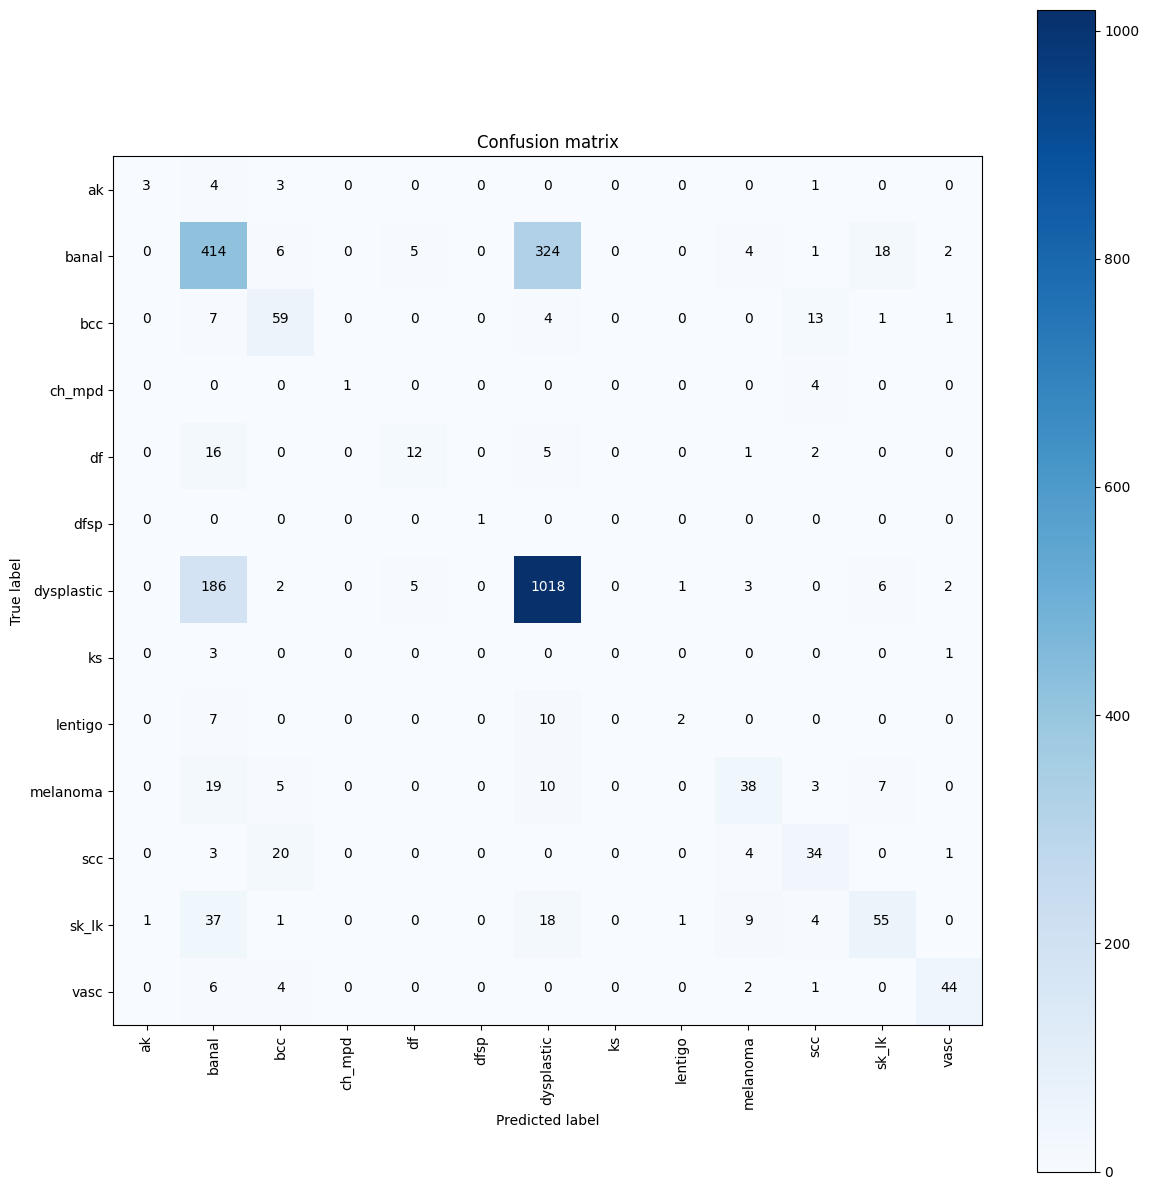

In [ ]:
# @title New confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          model_no,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, folder_name = "model_files_folder",**kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(12,12),**kwargs)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig(f"{folder_name}/kfold_{model_no}.png")
    plt.show()

# %% variables

classes = {
  'ak': 0,
 'banal': 1,
 'bcc': 2,
 'ch_mpd': 3,
 'df': 4,
 'dfsp': 5,
 'dysplastic': 6,
 'ks': 7,
 'lentigo': 8,
 'melanoma': 9,
 'scc': 10,
 'sk_lk': 11,
 'vasc': 12,
}

df = Globals.eval_df

gt_labels = df['groundtruth'].values
predictions = df['prediction'].values

cm = metrics.confusion_matrix(gt_labels, predictions)

plot_confusion_matrix(cm, classes=classes, model_no = 1)


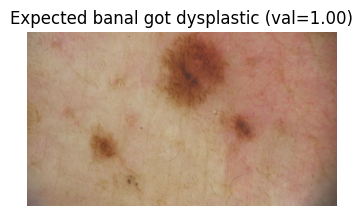

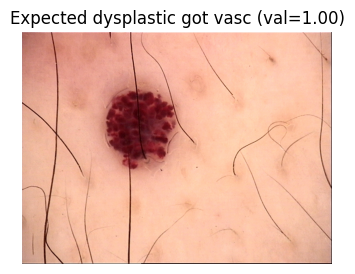

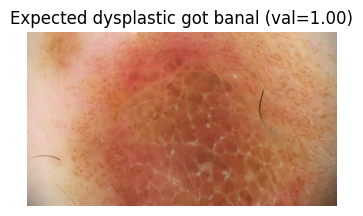

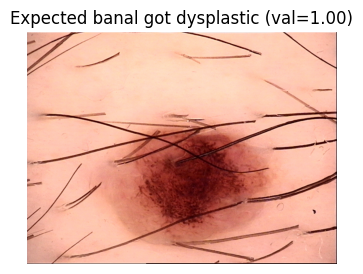

index prediction_name  prediction  max_prediction_float  \
2455  12232      dysplastic           6              0.999058   
291    1475            vasc          12              0.998609   
1140   5728           banal           1              0.998591   
660    3231      dysplastic           6              0.998058   
1186   5950      dysplastic           6              0.997913   
...     ...             ...         ...                   ...   
1464   7400             scc          10              0.339602   
640    3120        melanoma           9              0.320852   
1659   8355         lentigo           8              0.288513   
298    1496             scc          10              0.269853   
2141  10627             scc          10              0.256714   

                                   all_prediction_float groundtruth_name  \
2455  [4.7917492e-06, 0.0008746712, 1.3238319e-05, 5...            banal   
291   [6.203664e-07, 0.0011428739, 4.0619393e-06, 7....       dysplastic   
1140  [1.5711583e-05, 0.9985905, 7.175021e-06, 1.104...       dysplastic   
660   [5.5623373e-06, 0.0018870806, 1.4322135e-06, 8...            banal   
1186  [7.933745e-06, 0.0013563924, 2.2787906e-06, 9....            banal   
...                                                 ...              ...   
1464  [0.006439011, 0.114785984, 0.11366664, 0.00460...         melanoma   
640   [0.002470273, 0.1680082, 0.162992, 0.012598963...              scc   
1659  [0.061936658, 0.03155775, 0.09115551, 0.003034...       dysplastic   
298   [0.009761637, 0.098950796, 0.20666371, 0.00928...               df   
2141  [0.0024440691, 0.051293723, 0.105119966, 0.026...             vasc   

      groundtruth  index     image_id  patient_id license   image_type split  \
2455            1  12232  DERM_992010  PID_533270   CC-BY  dermoscopic  test   
291             6   1475  DERM_210227  PID_866687   CC-BY  dermoscopic  test   
1140            6   5728  DERM_515017  PID_758208   CC-BY  dermoscopic  test   
660             1   3231  DERM_337418  PID_954191   CC-BY  dermoscopic  test   
1186            1   5950  DERM_532081  PID_770135   CC-BY  dermoscopic  test   
...           ...    ...          ...         ...     ...          ...   ...   
1464            9   7400  DERM_639381  PID_879806   CC-BY  dermoscopic  test   
640            10   3120  DERM_330225  PID_497184   CC-BY  dermoscopic  test   
1659            6   8355  DERM_708524  PID_130254   CC-BY  dermoscopic  test   
298             4   1496  DERM_211759  PID_503791   CC-BY  dermoscopic  test   
2141           12  10627  DERM_875449  PID_202274   CC-BY  dermoscopic  test   

         super_class malignancy     main_class_1     main_class_2  \
2455     melanocytic     benign            banal       junctional   
291      melanocytic     benign       dysplastic       junctional   
1140     melanocytic     benign       dysplastic         compound   
660      melanocytic     benign            banal         compound   
1186     melanocytic     benign            banal         compound   
...              ...        ...              ...              ...   
1464     melanocytic  malignant         melanoma    acral_nodular   
640   nonmelanocytic  malignant    keratinocytic    keratinocytic   
1659     melanocytic     benign       dysplastic       junctional   
298   nonmelanocytic     benign  skin_appendages  skin_appendages   
2141  nonmelanocytic     benign         vascular         vascular   

                    sub_class       label  \
2455               congenital       banal   
291                spitz_reed  dysplastic   
1140                 compound  dysplastic   
660                  compound       banal   
1186                 compound       banal   
...                       ...         ...   
1464            acral_nodular    melanoma   
640   squamous_cell_carcinoma         scc   
1659               junctional  dysplastic   
298            dermatofibroma          df   
2141       pyogenic_granulo

In [ ]:
# @title Display model failures
# These are examples that the model returned high confidence for a prediction
# class different from the groundtruth.
def display_failure(num_images=4):
  # Combine the eval_df and the validation DataFrame
  df = pd.concat(
      [Globals.eval_df.reset_index(), Globals.df_validate.reset_index()], axis=1
  )
  assert list(df['groundtruth_name']) == list(
      df['label']
  ), f'Concatenated data has a bug - two columns that should match do not :('
  # Get the rows where the prediction was incorrect
  df = df[df['prediction_name'] != df['groundtruth_name']]
  df = df.sort_values(by='max_prediction_float', ascending=False)
  for i in range(num_images):
    row = df.iloc[i]
    img_path = row['img_path']
    gt = row['groundtruth_name']
    p = row['prediction_name']
    val = row['max_prediction_float']
    display_image(
        Globals.gcs_bucket,
        img_path,
        title=f'Expected {gt} got {p} (val={val:.2f})',
    )
  return df


display_failure()

# Results for MultiLayer Perceptron (similar model to Fully Connected Layer part of Deep Learning Training)

In [ ]:
# @title Classification report for MLP
import sklearn


def get_classification_report(eval_df):
  gt_labels = eval_df[f'groundtruth_name'].values
  pred = eval_df[f'prediction_name'].values
  classification_report = sklearn.metrics.classification_report(
      y_true=gt_labels, y_pred=pred
  )
  print('Classification report:')
  print(classification_report)


get_classification_report(Globals.eval_df)

Classification report:
              precision    recall  f1-score   support

          ak       0.12      0.09      0.11        11
       banal       0.50      0.62      0.55       774
         bcc       0.53      0.71      0.60        85
      ch_mpd       0.20      0.20      0.20         5
          df       0.58      0.58      0.58        36
        dfsp       0.50      1.00      0.67         1
  dysplastic       0.75      0.64      0.69      1223
          ks       0.00      0.00      0.00         4
     lentigo       0.29      0.11      0.15        19
    melanoma       0.54      0.60      0.57        82
         scc       0.61      0.44      0.51        62
       sk_lk       0.53      0.53      0.53       126
        vasc       0.91      0.70      0.79        57

    accuracy                           0.62      2485
   macro avg       0.47      0.48      0.46      2485
weighted avg       0.64      0.62      0.62      2485



In [ ]:
# @title Other metrics (cohen kappa, matthews coefficient, log loss) for XGBoost
from sklearn import metrics


def get_other_eval_metrics(eval_df):
  label_names = eval_df[f'groundtruth_name'].values
  label_ints = eval_df[f'groundtruth'].values
  pred_names = eval_df[f'prediction_name'].values
  pred_floats = list(eval_df[f'all_prediction_float'].values)
  predictions = tf.keras.utils.to_categorical(
      eval_df[f'prediction'].values, num_classes=len(Globals.all_col_vals)
  )
  # metrics:
  cohen_kappa = metrics.cohen_kappa_score(
      label_names, pred_names
  )  # target: 0.8
  labels = np.unique(label_names)

  matthews = metrics.matthews_corrcoef(label_names, pred_names)  # target: 0.7
  log_loss = metrics.log_loss(label_ints, pred_floats)  # target: 0
  auc = metrics.roc_auc_score(label_names, predictions, multi_class='ovr',average=None)
  auc_string = []
  for i, label in enumerate(labels):
    auc_string.append(f'{label}: {auc[i]}')
  return {
      'cohen_kappa': cohen_kappa,
      'matthews': matthews,
      'log_loss': log_loss,
      'auc': auc_string
  }


evals = get_other_eval_metrics(Globals.eval_df)

print(json.dumps(evals, indent=4))

{
    "cohen_kappa": 0.4247264590047415,
    "matthews": 0.42856675097761465,
    "log_loss": 2.736266729003095,
    "auc": [
        "ak: 0.5440398324391856",
        "banal: 0.6702855214095751",
        "bcc: 0.8416911764705883",
        "ch_mpd: 0.5991935483870967",
        "df: 0.7886041921872874",
        "dfsp: 0.9997987117552335",
        "dysplastic: 0.7166692799006884",
        "ks: 0.4995969367190649",
        "lentigo: 0.5516177914372304",
        "melanoma: 0.7902494848918526",
        "scc: 0.7142338876093354",
        "sk_lk: 0.7531557627996797",
        "vasc: 0.8500534697534611"
    ]
}


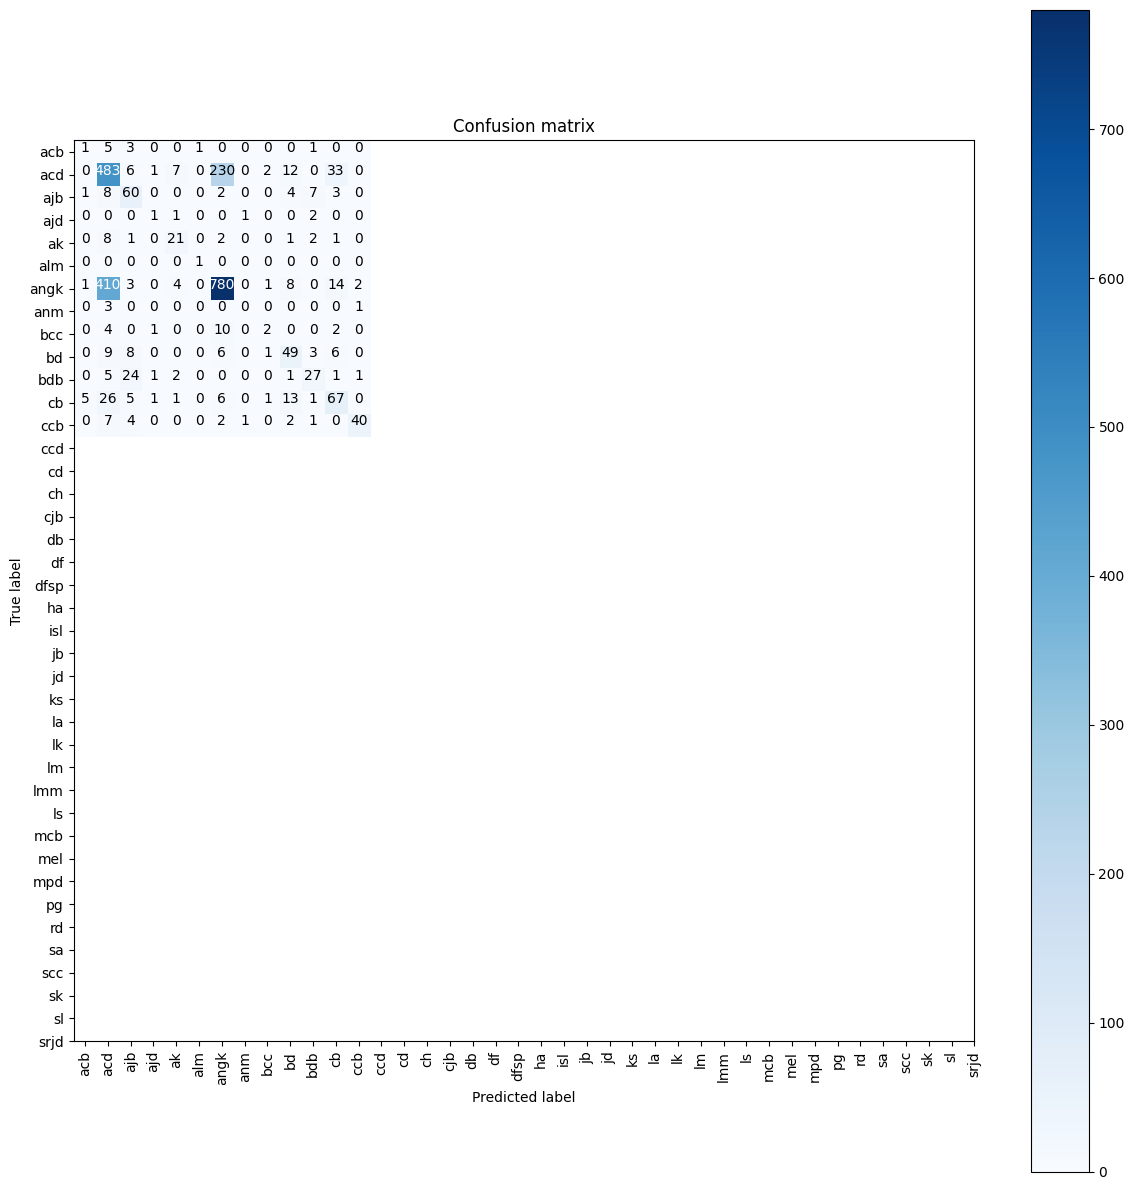

In [ ]:
# @title New confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          model_no,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, folder_name = "model_files_folder",**kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(12,12),**kwargs)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig(f"{folder_name}/kfold_{model_no}.png")
    plt.show()

# %% variables

classes = {
    "acb": 0,
    "acd":1,
    "ajb":2,
    "ajd":3,
    "ak":4,
    "alm":5,
    "angk":6,
    "anm":7,
    "bcc":8,
    "bd":9,
    "bdb":10,
    "cb":11,
    "ccb":12,
    "ccd":13,
    "cd":14,
    "ch":15,
    "cjb":16,
    "db":17,
    "df":18,
    "dfsp":19,
    "ha":20,
    "isl":21,
    "jb":22,
    "jd":23,
    "ks":24,
    "la":25,
    "lk":26,
    "lm":27,
    "lmm":28,
    "ls":29,
    "mcb":30,
    "mel":31,
    "mpd":32,
    "pg":33,
    "rd":34,
    "sa":35,
    "scc":36,
    "sk":37,
    "sl":38,
    "srjd":39,
}

df = Globals.eval_df

gt_labels = df['groundtruth'].values
predictions = df['prediction'].values

cm = metrics.confusion_matrix(gt_labels, predictions)

plot_confusion_matrix(cm, classes=classes, model_no = 1)


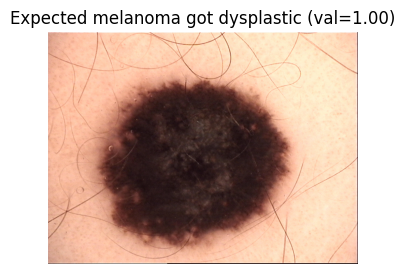

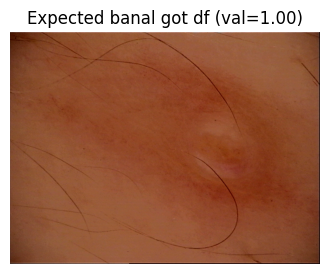

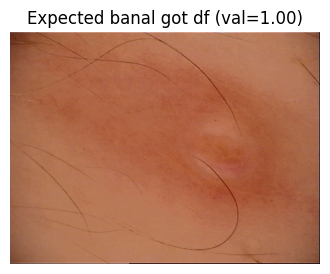

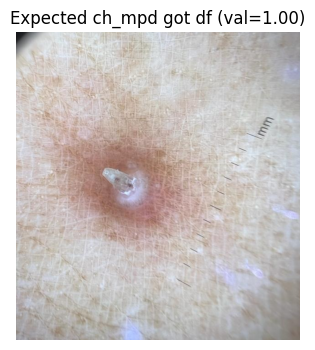

index prediction_name  prediction  max_prediction_float  \
910    4580      dysplastic           6              1.000000   
2098  10446              df           4              1.000000   
1331   6768              df           4              1.000000   
2426  12136              df           4              1.000000   
1280   6445      dysplastic           6              1.000000   
...     ...             ...         ...                   ...   
915    4613             bcc           2              0.414252   
2410  12087              df           4              0.365220   
2141  10627              ks           7              0.363931   
2315  11608           banal           1              0.350255   
640    3120             bcc           2              0.286234   

                                   all_prediction_float groundtruth_name  \
910   [1.939067437009183e-48, 2.523117589708704e-19,...         melanoma   
2098  [4.738262683602216e-30, 1.1107362109367476e-17...            banal   
1331  [1.8791559942138554e-26, 1.4157451998605935e-1...            banal   
2426  [1.6530859843097738e-27, 4.509347705837346e-17...           ch_mpd   
1280  [4.677554369198808e-36, 1.1806530246093137e-13...            banal   
...                                                 ...              ...   
915   [0.00015451996026679315, 0.0055137792090366785...         melanoma   
2410  [0.0033010729237252286, 0.34459257723237413, 1...            banal   
2141  [0.01429758000539311, 0.017444152860850944, 0....             vasc   
2315  [0.02481514020468063, 0.35025489979126684, 0.0...               df   
640   [0.0003879531751689594, 0.12179810271860245, 0...              scc   

      groundtruth  index     image_id  patient_id license   image_type split  \
910             9   4580  DERM_433679  PID_825788   CC-BY  dermoscopic  test   
2098            1  10446  DERM_862440  PID_402466   CC-BY  dermoscopic  test   
1331            1   6768  DERM_592450  PID_402466   CC-BY  dermoscopic  test   
2426            3  12136  DERM_985566  PID_999599   CC-BY  dermoscopic  test   
1280            1   6445  DERM_568018  PID_282864   CC-BY  dermoscopic  test   
...           ...    ...          ...         ...     ...          ...   ...   
915             9   4613  DERM_436592  PID_405039   CC-BY  dermoscopic  test   
2410            1  12087  DERM_985517  PID_999998   CC-BY  dermoscopic  test   
2141           12  10627  DERM_875449  PID_202274   CC-BY  dermoscopic  test   
2315            4  11608  DERM_949532  PID_503791   CC-BY  dermoscopic  test   
640            10   3120  DERM_330225  PID_497184   CC-BY  dermoscopic  test   

         super_class malignancy     main_class_1     main_class_2  \
910      melanocytic  malignant         melanoma         melanoma   
2098     melanocytic     benign            banal           dermal   
1331     melanocytic     benign            banal           dermal   
2426  nonmelanocytic  malignant    keratinocytic    keratinocytic   
1280     melanocytic     benign            banal       junctional   
...              ...        ...              ...              ...   
915      melanocytic  malignant         melanoma         melanoma   
2410     melanocytic     benign            banal         compound   
2141  nonmelanocytic     benign         vascular         vascular   
2315  nonmelanocytic     benign  skin_appendages  skin_appendages   
640   nonmelanocytic  malignant    keratinocytic    keratinocytic   

                    sub_class     label  \
910                  melanoma  melanoma   
2098                   dermal     banal   
1331                   dermal     banal   
2426           cutaneous_horn    ch_mpd   
1280               junctional     banal   
...                       ...       ...   
915                  melanoma  melanoma   
2410                    acral     banal   
2141       pyogenic_granuloma      vasc   
2315           dermatofibroma        df   
640   squamous_cell_carcinoma       scc   

     

In [ ]:
# @title Display model failures
# These are examples that the model returned high confidence for a prediction
# class different from the groundtruth.
def display_failure(num_images=4):
  # Combine the eval_df and the validation DataFrame
  df = pd.concat(
      [Globals.eval_df.reset_index(), Globals.df_validate.reset_index()], axis=1
  )
  assert list(df['groundtruth_name']) == list(
      df['label']
  ), f'Concatenated data has a bug - two columns that should match do not :('
  # Get the rows where the prediction was incorrect
  df = df[df['prediction_name'] != df['groundtruth_name']]
  df = df.sort_values(by='max_prediction_float', ascending=False)
  for i in range(num_images):
    row = df.iloc[i]
    img_path = row['img_path']
    gt = row['groundtruth_name']
    p = row['prediction_name']
    val = row['max_prediction_float']
    display_image(
        Globals.gcs_bucket,
        img_path,
        title=f'Expected {gt} got {p} (val={val:.2f})',
    )
  return df


display_failure()

# Results for kNN

In [ ]:
# @title Classification report for kNN
import sklearn


def get_classification_report(eval_df):
  gt_labels = eval_df[f'groundtruth_name'].values
  pred = eval_df[f'prediction_name'].values
  classification_report = sklearn.metrics.classification_report(
      y_true=gt_labels, y_pred=pred
  )
  print('Classification report:')
  print(classification_report)


get_classification_report(Globals.eval_df)

Classification report:
              precision    recall  f1-score   support

          ak       0.50      0.09      0.15        11
       banal       0.42      0.44      0.43       774
         bcc       0.40      0.38      0.39        85
      ch_mpd       0.25      0.40      0.31         5
          df       0.09      0.08      0.09        36
        dfsp       0.00      0.00      0.00         1
  dysplastic       0.66      0.65      0.66      1223
          ks       0.00      0.00      0.00         4
     lentigo       0.14      0.16      0.15        19
    melanoma       0.23      0.23      0.23        82
         scc       0.36      0.34      0.35        62
       sk_lk       0.29      0.27      0.28       126
        vasc       0.62      0.58      0.60        57

    accuracy                           0.52      2485
   macro avg       0.30      0.28      0.28      2485
weighted avg       0.52      0.52      0.52      2485



In [ ]:
# @title Other metrics (cohen kappa, matthews coefficient, log loss) for XGBoost
from sklearn import metrics


def get_other_eval_metrics(eval_df):
  label_names = eval_df[f'groundtruth_name'].values
  label_ints = eval_df[f'groundtruth'].values
  pred_names = eval_df[f'prediction_name'].values
  pred_floats = list(eval_df[f'all_prediction_float'].values)
  predictions = tf.keras.utils.to_categorical(
      eval_df[f'prediction'].values, num_classes=len(Globals.all_col_vals)
  )
  # metrics:
  cohen_kappa = metrics.cohen_kappa_score(
      label_names, pred_names
  )  # target: 0.8
  labels = np.unique(label_names)

  matthews = metrics.matthews_corrcoef(label_names, pred_names)  # target: 0.7
  log_loss = metrics.log_loss(label_ints, pred_floats)  # target: 0
  auc = metrics.roc_auc_score(label_names, predictions, multi_class='ovr',average=None)
  auc_string = []
  for i, label in enumerate(labels):
    auc_string.append(f'{label}: {auc[i]}')
  return {
      'cohen_kappa': cohen_kappa,
      'matthews': matthews,
      'log_loss': log_loss,
      'auc': auc_string
  }


evals = get_other_eval_metrics(Globals.eval_df)

print(json.dumps(evals, indent=4))

{
    "cohen_kappa": 0.26093815251887,
    "matthews": 0.26100942647234543,
    "log_loss": 17.40538594243082,
    "auc": [
        "ak: 0.5452524435952083",
        "banal: 0.5820609764753676",
        "bcc: 0.678235294117647",
        "ch_mpd: 0.6987903225806451",
        "df: 0.535337552742616",
        "dfsp: 0.499194847020934",
        "dysplastic: 0.6633848982717668",
        "ks: 0.4989923417976622",
        "lentigo: 0.5750949758825288",
        "melanoma: 0.6025369710625945",
        "scc: 0.6615133199313035",
        "sk_lk: 0.6175403890537422",
        "vasc: 0.7853550680655511"
    ]
}


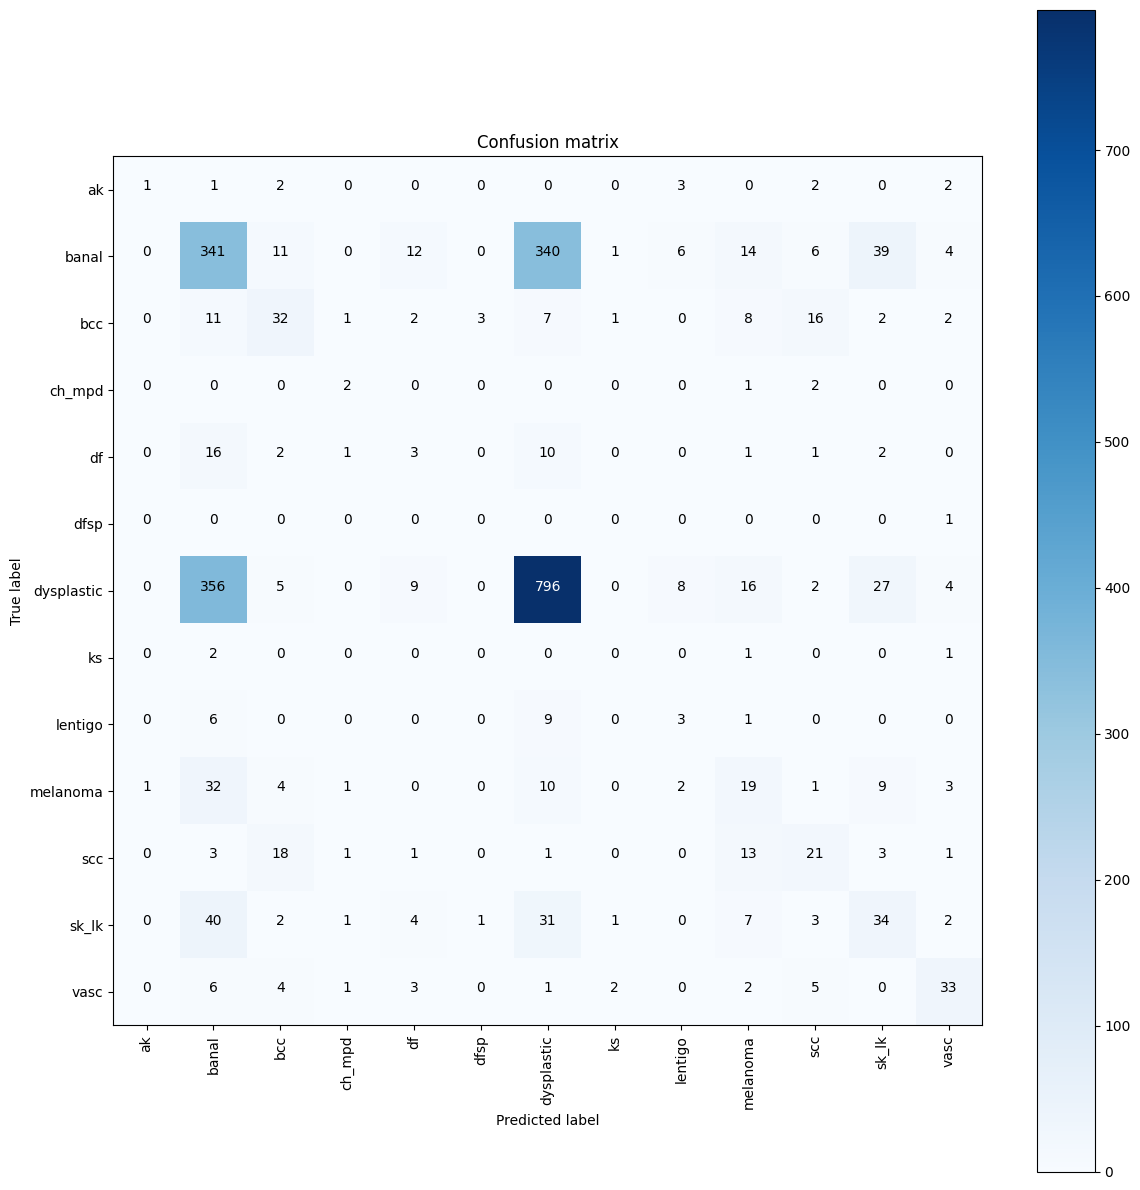

In [ ]:
# @title New confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          model_no,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, folder_name = "model_files_folder",**kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(12,12),**kwargs)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig(f"{folder_name}/kfold_{model_no}.png")
    plt.show()

# %% variables

classes = {
  'ak': 0,
 'banal': 1,
 'bcc': 2,
 'ch_mpd': 3,
 'df': 4,
 'dfsp': 5,
 'dysplastic': 6,
 'ks': 7,
 'lentigo': 8,
 'melanoma': 9,
 'scc': 10,
 'sk_lk': 11,
 'vasc': 12,
}

df = Globals.eval_df

gt_labels = df['groundtruth'].values
predictions = df['prediction'].values

cm = metrics.confusion_matrix(gt_labels, predictions)

plot_confusion_matrix(cm, classes=classes, model_no = 1)


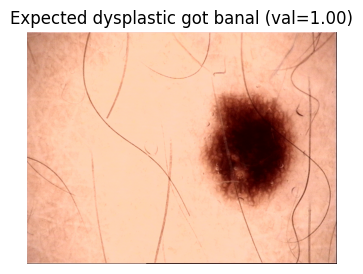

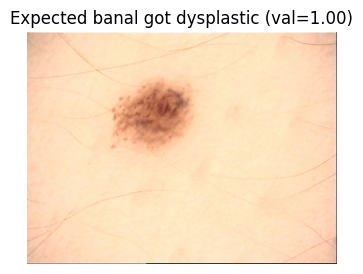

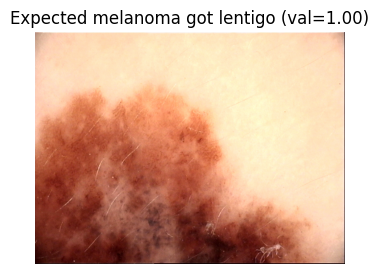

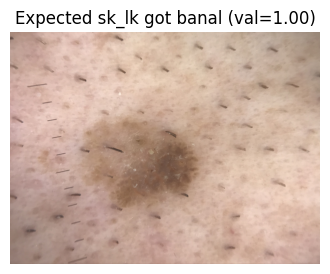

index prediction_name  prediction  max_prediction_float  \
4        42           banal           1                   1.0   
1685   8456      dysplastic           6                   1.0   
1682   8453         lentigo           8                   1.0   
1680   8450           banal           1                   1.0   
1678   8439      dysplastic           6                   1.0   
...     ...             ...         ...                   ...   
813    3994      dysplastic           6                   1.0   
812    3988           sk_lk          11                   1.0   
810    3971           banal           1                   1.0   
809    3949      dysplastic           6                   1.0   
2484  12342             scc          10                   1.0   

                                   all_prediction_float groundtruth_name  \
4     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       dysplastic   
1685  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...            banal   
1682  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...         melanoma   
1680  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            sk_lk   
1678  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...            banal   
...                                                 ...              ...   
813   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...            banal   
812   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         melanoma   
810   [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       dysplastic   
809   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...            banal   
2484  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              bcc   

      groundtruth  index     image_id  patient_id license   image_type split  \
4               6     42  DERM_103360  PID_809408   CC-BY  dermoscopic  test   
1685            1   8456  DERM_715660  PID_520072   CC-BY  dermoscopic  test   
1682            9   8453  DERM_715530  PID_575385   CC-BY  dermoscopic  test   
1680           11   8450  DERM_715285  PID_869215   CC-BY  dermoscopic  test   
1678            1   8439  DERM_714168  PID_176927   CC-BY  dermoscopic  test   
...           ...    ...          ...         ...     ...          ...   ...   
813             1   3994  DERM_393766  PID_132934   CC-BY  dermoscopic  test   
812             9   3988  DERM_393152  PID_573564   CC-BY  dermoscopic  test   
810             6   3971  DERM_392013  PID_566799   CC-BY  dermoscopic  test   
809             1   3949  DERM_390831  PID_352001   CC-BY  dermoscopic  test   
2484            2  12342  DERM_999985  PID_526575   CC-BY  dermoscopic  test   

         super_class malignancy   main_class_1     main_class_2  \
4        melanocytic     benign     dysplastic       junctional   
1685     melanocytic     benign          banal         compound   
1682     melanocytic  malignant       melanoma         melanoma   
1680  nonmelanocytic     benign  keratinocytic    keratinocytic   
1678     melanocytic     benign          banal       junctional   
...              ...        ...            ...              ...   
813      melanocytic     benign          banal         compound   
812      melanocytic  malignant       melanoma  lentigo_maligna   
810      melanocytic     benign     dysplastic       junctional   
809      melanocytic     benign          banal       junctional   
2484  nonmelanocytic  malignant  keratinocytic    keratinocytic   

                 sub_class       label  \
4               junctional  dysplastic   
1685              compound       banal   
1682              melanoma    melanoma   
1680  seborrheic_keratosis       sk_lk   
1678            junctional       banal   
...                    ...         ...   
813             congenital       banal   
812        lentigo_maligna    melanoma   
810             junctional  dysplastic   
809             junctional       banal   
2484  basal_cell_carcinoma         bcc   

                                         

In [ ]:
# @title Display model failures
# These are examples that the model returned high confidence for a prediction
# class different from the groundtruth.
def display_failure(num_images=4):
  # Combine the eval_df and the validation DataFrame
  df = pd.concat(
      [Globals.eval_df.reset_index(), Globals.df_validate.reset_index()], axis=1
  )
  assert list(df['groundtruth_name']) == list(
      df['label']
  ), f'Concatenated data has a bug - two columns that should match do not :('
  # Get the rows where the prediction was incorrect
  df = df[df['prediction_name'] != df['groundtruth_name']]
  df = df.sort_values(by='max_prediction_float', ascending=False)
  for i in range(num_images):
    row = df.iloc[i]
    img_path = row['img_path']
    gt = row['groundtruth_name']
    p = row['prediction_name']
    val = row['max_prediction_float']
    display_image(
        Globals.gcs_bucket,
        img_path,
        title=f'Expected {gt} got {p} (val={val:.2f})',
    )
  return df


display_failure()

# Results for Logistic Regression

In [ ]:
# @title Classification report for Logistic Regression
import sklearn


def get_classification_report(eval_df):
  gt_labels = eval_df[f'groundtruth_name'].values
  pred = eval_df[f'prediction_name'].values
  classification_report = sklearn.metrics.classification_report(
      y_true=gt_labels, y_pred=pred
  )
  print('Classification report:')
  print(classification_report)


get_classification_report(Globals.eval_df)

Classification report:
              precision    recall  f1-score   support

          ak       0.60      0.27      0.38        11
       banal       0.58      0.56      0.57       774
         bcc       0.61      0.67      0.64        85
      ch_mpd       1.00      0.20      0.33         5
          df       0.54      0.58      0.56        36
        dfsp       1.00      1.00      1.00         1
  dysplastic       0.74      0.78      0.76      1223
          ks       0.00      0.00      0.00         4
     lentigo       0.36      0.26      0.30        19
    melanoma       0.67      0.56      0.61        82
         scc       0.52      0.65      0.58        62
       sk_lk       0.64      0.53      0.58       126
        vasc       0.90      0.79      0.84        57

    accuracy                           0.67      2485
   macro avg       0.63      0.53      0.55      2485
weighted avg       0.67      0.67      0.67      2485



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# @title Other metrics (cohen kappa, matthews coefficient, log loss) for XGBoost
from sklearn import metrics


def get_other_eval_metrics(eval_df):
  label_names = eval_df[f'groundtruth_name'].values
  label_ints = eval_df[f'groundtruth'].values
  pred_names = eval_df[f'prediction_name'].values
  pred_floats = list(eval_df[f'all_prediction_float'].values)
  predictions = tf.keras.utils.to_categorical(
      eval_df[f'prediction'].values, num_classes=len(Globals.all_col_vals)
  )
  # metrics:
  cohen_kappa = metrics.cohen_kappa_score(
      label_names, pred_names
  )  # target: 0.8
  labels = np.unique(label_names)

  matthews = metrics.matthews_corrcoef(label_names, pred_names)  # target: 0.7
  log_loss = metrics.log_loss(label_ints, pred_floats)  # target: 0
  auc = metrics.roc_auc_score(label_names, predictions, multi_class='ovr',average=None)
  auc_string = []
  for i, label in enumerate(labels):
    auc_string.append(f'{label}: {auc[i]}')
  return {
      'cohen_kappa': cohen_kappa,
      'matthews': matthews,
      'log_loss': log_loss,
      'auc': auc_string
  }


evals = get_other_eval_metrics(Globals.eval_df)

print(json.dumps(evals, indent=4))

{
    "cohen_kappa": 0.4921987241752296,
    "matthews": 0.49264545462657466,
    "log_loss": 0.9239168601415578,
    "auc": [
        "ak: 0.6359594326449621",
        "banal: 0.6884794693705572",
        "bcc: 0.8277941176470587",
        "ch_mpd: 0.6",
        "df: 0.7879916972914115",
        "dfsp: 1.0",
        "dysplastic: 0.7556886433168808",
        "ks: 0.5",
        "lentigo: 0.6297541298501728",
        "melanoma: 0.7757021203170834",
        "scc: 0.8149454821402421",
        "sk_lk: 0.7578187555932363",
        "vasc: 0.8937071880690193"
    ]
}


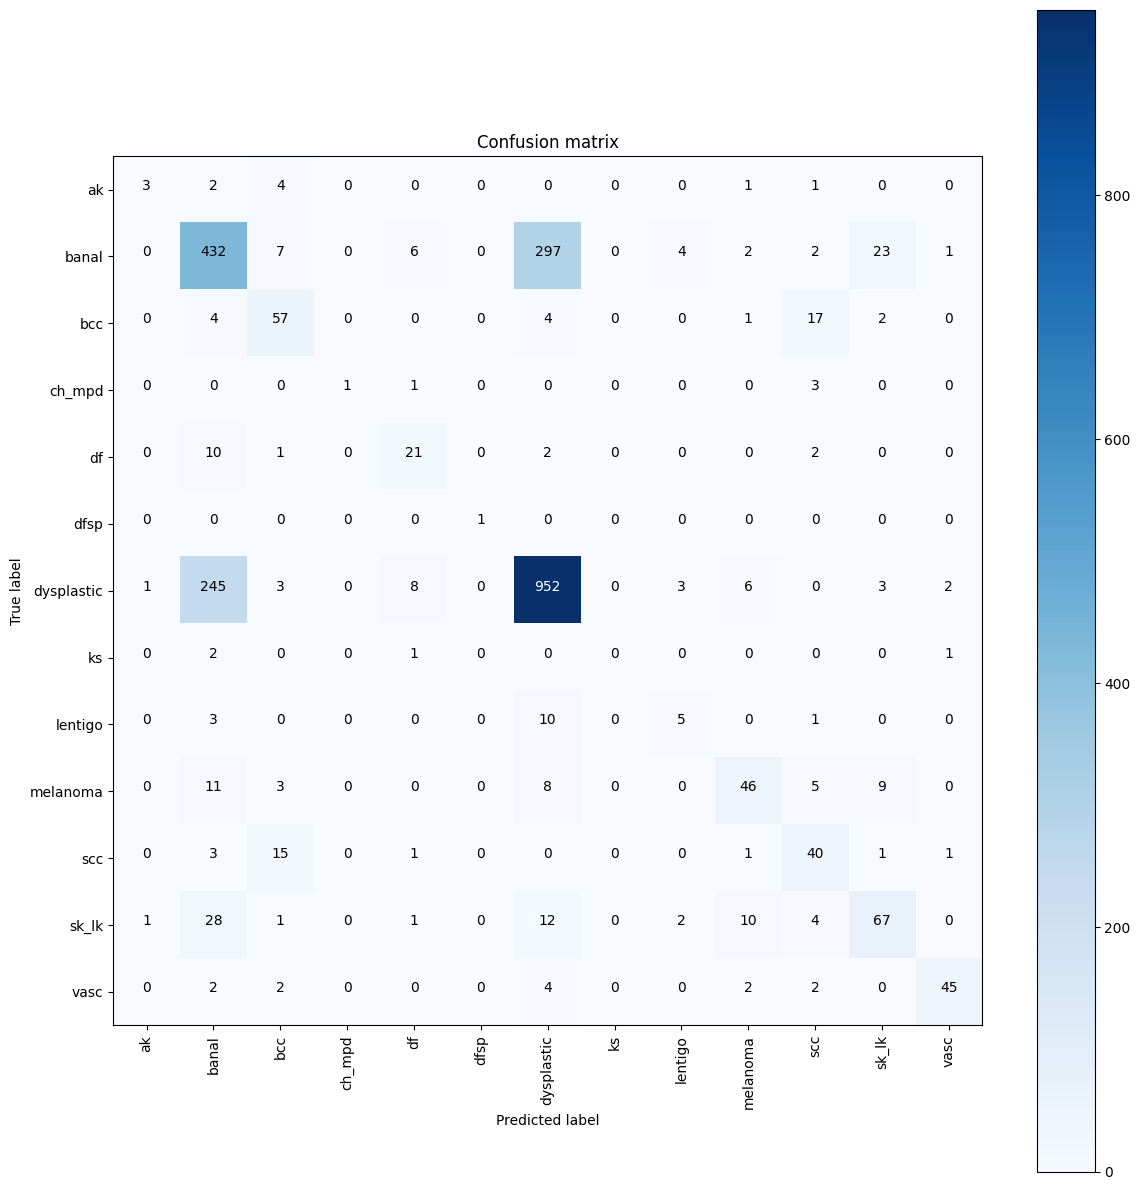

In [ ]:
# @title New confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          model_no,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, folder_name = "model_files_folder",**kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(12,12),**kwargs)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig(f"{folder_name}/kfold_{model_no}.png")
    plt.show()

# %% variables

classes = {
  'ak': 0,
 'banal': 1,
 'bcc': 2,
 'ch_mpd': 3,
 'df': 4,
 'dfsp': 5,
 'dysplastic': 6,
 'ks': 7,
 'lentigo': 8,
 'melanoma': 9,
 'scc': 10,
 'sk_lk': 11,
 'vasc': 12,
}

df = Globals.eval_df

gt_labels = df['groundtruth'].values
predictions = df['prediction'].values

cm = metrics.confusion_matrix(gt_labels, predictions)

plot_confusion_matrix(cm, classes=classes, model_no = 1)

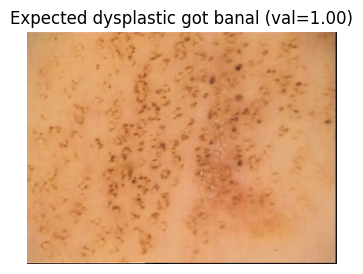

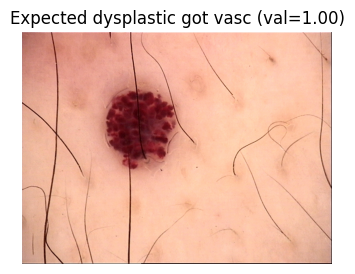

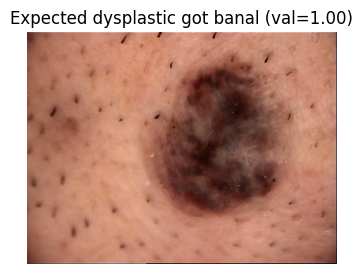

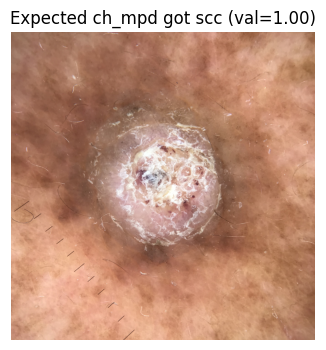

index prediction_name  prediction  max_prediction_float  \
1054   5296           banal           1              0.999999   
291    1475            vasc          12              0.999981   
1018   5148           banal           1              0.999695   
2428  12138             scc          10              0.999628   
2257  11301             bcc           2              0.999570   
...     ...             ...         ...                   ...   
614    3034         lentigo           8              0.353756   
363    1863             bcc           2              0.353620   
473    2334      dysplastic           6              0.339992   
261    1317             scc          10              0.317970   
743    3663        melanoma           9              0.304976   

                                   all_prediction_float groundtruth_name  \
1054  [2.2268622701337813e-10, 0.999998660158079, 1....       dysplastic   
291   [4.593092334298444e-11, 1.3382727131501538e-05...       dysplastic   
1018  [1.350811622842813e-08, 0.9996950156549277, 0....       dysplastic   
2428  [5.2930921434452884e-08, 1.7395397122797796e-0...           ch_mpd   
2257  [8.693511345992279e-08, 1.4378826626748607e-05...              scc   
...                                                 ...              ...   
614   [0.14456446722543217, 0.23795088883961665, 0.0...            sk_lk   
363   [0.32198317644081226, 0.00012516391062559465, ...               ak   
473   [7.039124853245954e-07, 0.3105032864017699, 0....            banal   
261   [8.786610411625013e-05, 0.30711348578414444, 0...              bcc   
743   [7.801998720944033e-05, 0.11068660424882293, 0...            banal   

      groundtruth  index     image_id  patient_id license   image_type split  \
1054            6   5296  DERM_481510  PID_214805   CC-BY  dermoscopic  test   
291             6   1475  DERM_210227  PID_866687   CC-BY  dermoscopic  test   
1018            6   5148  DERM_472378  PID_525434   CC-BY  dermoscopic  test   
2428            3  12138  DERM_985568  PID_999601   CC-BY  dermoscopic  test   
2257           10  11301  DERM_926146  PID_682223   CC-BY  dermoscopic  test   
...           ...    ...          ...         ...     ...          ...   ...   
614            11   3034  DERM_324836  PID_897293   CC-BY  dermoscopic  test   
363             0   1863  DERM_239449  PID_656166   CC-BY  dermoscopic  test   
473             1   2334  DERM_275938  PID_254529   CC-BY  dermoscopic  test   
261             2   1317  DERM_198185  PID_661664   CC-BY  dermoscopic  test   
743             1   3663  DERM_370301  PID_345461   CC-BY  dermoscopic  test   

         super_class     malignancy   main_class_1   main_class_2  \
1054     melanocytic         benign     dysplastic     junctional   
291      melanocytic         benign     dysplastic     junctional   
1018     melanocytic         benign     dysplastic       compound   
2428  nonmelanocytic      malignant  keratinocytic  keratinocytic   
2257  nonmelanocytic      malignant  keratinocytic  keratinocytic   
...              ...            ...            ...            ...   
614   nonmelanocytic         benign  keratinocytic  keratinocytic   
363   nonmelanocytic  indeterminate  keratinocytic  keratinocytic   
473      melanocytic         benign          banal     junctional   
261   nonmelanocytic      malignant  keratinocytic  keratinocytic   
743      melanocytic         benign          banal         dermal   

                    sub_class       label  \
1054               junctional  dysplastic   
291                spitz_reed  dysplastic   
1018               congenital  dysplastic   
2428           cutaneous_horn      ch_mpd   
2257  squamous_cell_carcinoma         scc   
...                       ...         ...   
614      seborrheic_keratosis       sk_lk   
363         actinic_keratosis          ak   
473                junctional       banal   
261      basal_cell_carcinoma         bcc   
743                    derm

In [ ]:
# @title Display model failures
# These are examples that the model returned high confidence for a prediction
# class different from the groundtruth.
def display_failure(num_images=4):
  # Combine the eval_df and the validation DataFrame
  df = pd.concat(
      [Globals.eval_df.reset_index(), Globals.df_validate.reset_index()], axis=1
  )
  assert list(df['groundtruth_name']) == list(
      df['label']
  ), f'Concatenated data has a bug - two columns that should match do not :('
  # Get the rows where the prediction was incorrect
  df = df[df['prediction_name'] != df['groundtruth_name']]
  df = df.sort_values(by='max_prediction_float', ascending=False)
  for i in range(num_images):
    row = df.iloc[i]
    img_path = row['img_path']
    gt = row['groundtruth_name']
    p = row['prediction_name']
    val = row['max_prediction_float']
    display_image(
        Globals.gcs_bucket,
        img_path,
        title=f'Expected {gt} got {p} (val={val:.2f})',
    )
  return df


display_failure()